## Consolidating our model runs

We have written a model to study whether our data is more likely to be drawn from the `standard` or `rocrit` models presented in van Saders et al. (2019).

We evaluate this using a mixture model, where:

\begin{equation}
p(\theta, P_{s} | D_i) = [P_s \text{KDE}_s(\theta) + (1-P_s)\text{KDE}_{Ro}(\theta)]p(D|\theta)p(P_{s})\, ,
\end{equation}

where $\theta$ are hyperparameters compared directly to measurements of our data in **mass, temperature, log age & log rotation**. $\rm KDE_s$ is a Kernel Density Estimate of the van Saders standard model, and $\rm \rm KDE_{Ro}$ is the same for the critical Rossby model.

If $P_s$ is close to or equal to zero, our set of asteroseismic age and rotation lies in favour of the conditions of the van Saders Rossby model being true, i.e. the weakened magnetic breaking theory.

The equation above functions only for a single star. We want the probability of one model or the other being true given our *entire* dataset, so we multiply all the posterior probabilities for each star together.

In practice, not all stars will inform this result: subgiants and cooler, less evolved stars will either be dominated by other angular momentum changes, or not yet experiencing the effect of weakened magnetic braking. We can study the effects different stellar groups have on the combined posterior estimate of $P_s$ by making the calculation using different stellar groups.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
sns.set_palette('colorblind')

In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
kics = ati.KIC.values
print(f'Working with {len(kics)} stars')

Working with 95 stars


Reading in the posterior samples

In [3]:
%%time
d = '/home/oliver/PhD/mnt/RDS/malatium/models/'
post_pa = []
for idx, kic in enumerate(kics):
    try:
        post_pa.append(pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
    except FileNotFoundError:
        ati.drop(index=idx, inplace=True)
        continue               

CPU times: user 13.3 s, sys: 1.4 s, total: 14.7 s
Wall time: 19.9 s


In an ideal world, we would multiply the posterior functions for every star. However we have samples instead of functions. We overcome this by multiplying the probability value in each of 100 bins for all stars, approximating the shape of a combined posterior function.

In [4]:
bins = np.linspace(0, 1, 100)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### The overall result:

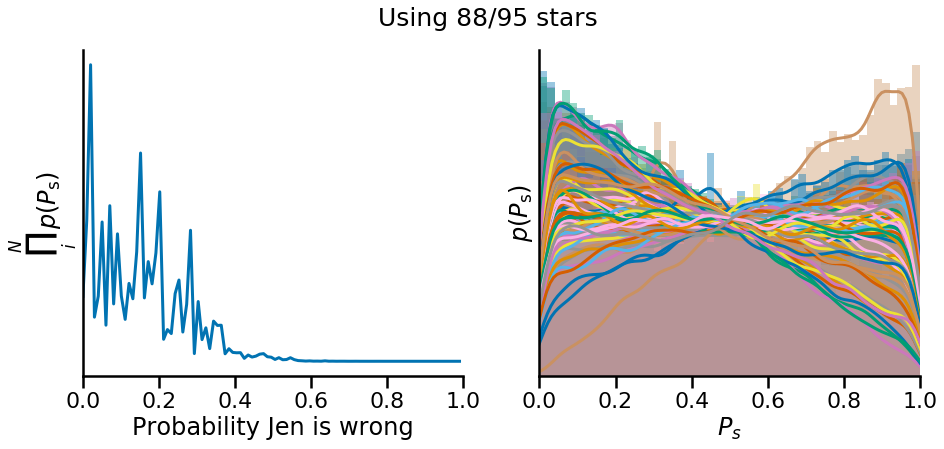

In [5]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], posterior)
ax[0].set_xlabel('Probability Jen is wrong')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
for n in post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(post_pa)}/95 stars', fontsize=25)

plt.show()

#### Comparing stellar type

In [6]:
print(ati.hrclass.unique())

['SG' 'MS' 'H']


Set up the classifications:

In [7]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'

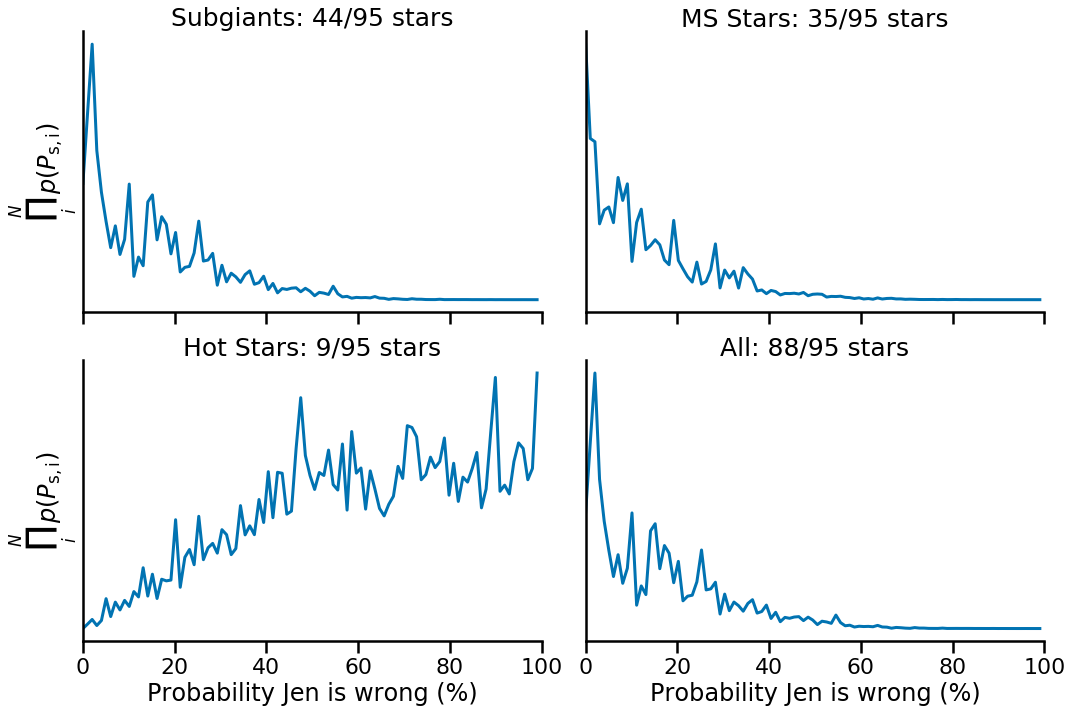

In [8]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists[sg])}/95 stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)

ax[1].plot(bins[:-1], np.prod(hists[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists[ms])}/95 stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)

ax[2].plot(bins[:-1], np.prod(hists[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists[h])}/95 stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)

ax[3].plot(bins[:-1], np.prod(hists[sg], axis=0))
ax[3].set_title(fr'All: {len(hists)}/95 stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

Here I've plotted the combined posterior probabilities for stars in certain evolutionary groups. They are all plotted on the same yscale, to show relative contributions to the total posterior estimate (lower right).

- Surprisingly, subgiants are strongly in favour of a critical Rossby number. Could this be due to a relatively conservative classification (logg < 4.2)?
- MS stars are strongly in favour of a critical Rossby number. This should be enough to satisfy anybody looking for a `smoking gun` in these rotation rates.
- Hot stars have relatively little to contribute, but weigh overall more heavily in favour of a standard model. Could this have to do with them not being covered by the KDE range?
- Overall, we find a strong agreement with Jen's proposal.

### A conservative check on KDE membership

Since Jen's 2019 models were intended only really to look at stars below the Kraft break, there may be some stars that were included in the posterior estimation, but weren't properly represented in Jen's models.

To mitigate this, I'll make a selection to remove any stars that weren't directly inside the parameter spaces of the two models.

In [9]:
stan = pd.read_csv('../data/jvs_models/standard_model.csv')
ro = pd.read_csv('../data/jvs_models/rocrit_model.csv')

In [10]:
cols = ['# Teff(K)', ' Prot(days)', ' Age(Gyr)', ' Mass(Msun)']
bound_s = [(stan[par].min(), stan[par].max()) for par in cols]
cols = ['#Teff(K)', ' Prot(days)', ' Age(Gyr)', ' Mass(Msun)']
bound_ro = [(ro[par].min(), ro[par].max()) for par in cols]

In [11]:
c = ati.copy(deep=True)
sel = []

cols = ['Teff', 'P', 'age', 'modmass']
for idx in c.index:
    par = [c.loc[idx][col] for col in cols]
    if not all(b[0] < v < b[1] for v, b in list(zip(par, bound_s))):
        c.drop(index=idx, inplace=True)
        sel.append(False)
    elif not all(b[0] < v < b[1] for v, b in list(zip(par, bound_s))):
        c.drop(index=idx, inplace=True)
    else:
        sel.append(True)
        pass

In [12]:
hists_sel = hists[sel]
sg = c['hrclass'] == 'SG'
ms = c['hrclass'] == 'MS'
h = c['hrclass'] == 'H'

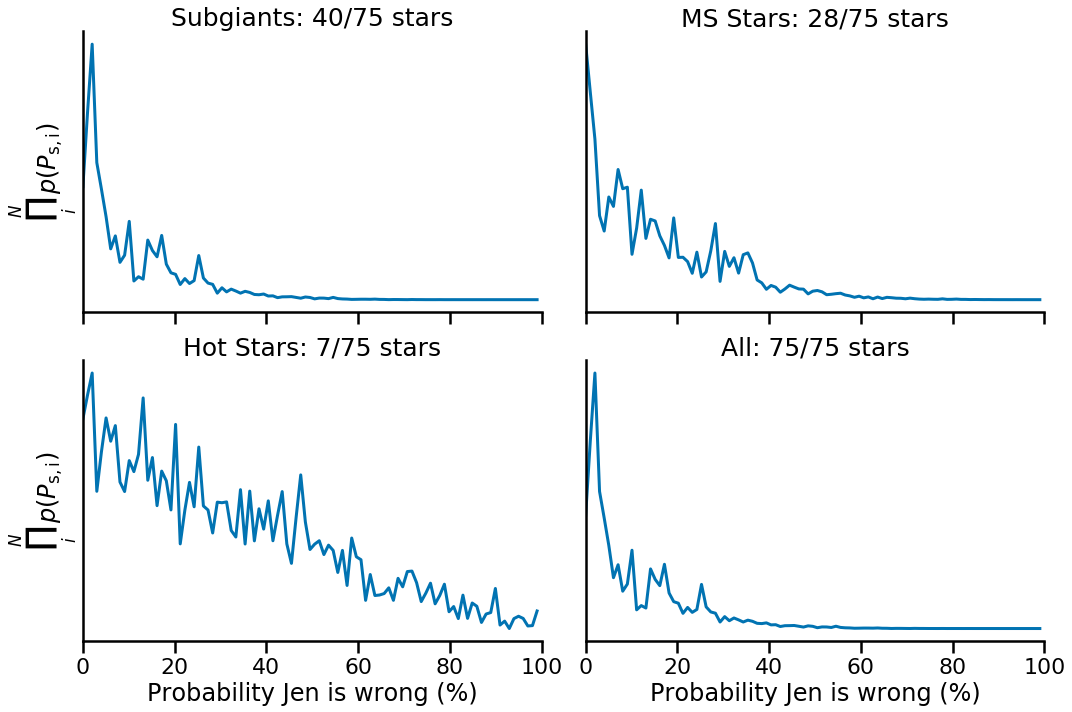

In [13]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel[sg])}/{len(c)} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)

ax[1].plot(bins[:-1], np.prod(hists_sel[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel[ms])}/{len(c)} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)

ax[2].plot(bins[:-1], np.prod(hists_sel[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel[h])}/{len(c)} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)

ax[3].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[3].set_title(fr'All: {len(hists_sel)}/{len(c)} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

These plots are **not sharing a y-axis**. When removing outlier stars, the result is still maintained, but the subgiants carry the vast majority of the weight. With MS stars only, magnetic braking is still the most probably outcome, fortunately.

- Can we increase the scope of the models to include later ages?
- Can we ensure both models capture the same temperature range?

### A check on convergence 

While we appear to have decent convergence on all parameters, there are some with low numbers of effective samples, or Rhat values that are high enough to raise eyebrows a little. We'll run the same checks, but with those removed.

We'll remove all stars with:
- Any of the core 4 parameters outside the KDE range (as in the example above)
- $n_{\rm eff} < 1000$ on splitting.
- $\hat{R} > 1.1$ on a rotational parameter.

In [14]:
f = c.copy(deep=True)
sel = (f.neff_split > 1000) & (f.rhat_flag != 'rhat_1')
hists_sel = hists_sel[sel]
sg = f[sel]['hrclass'] == 'SG'
ms = f[sel]['hrclass'] == 'MS'
h = f[sel]['hrclass'] == 'H'

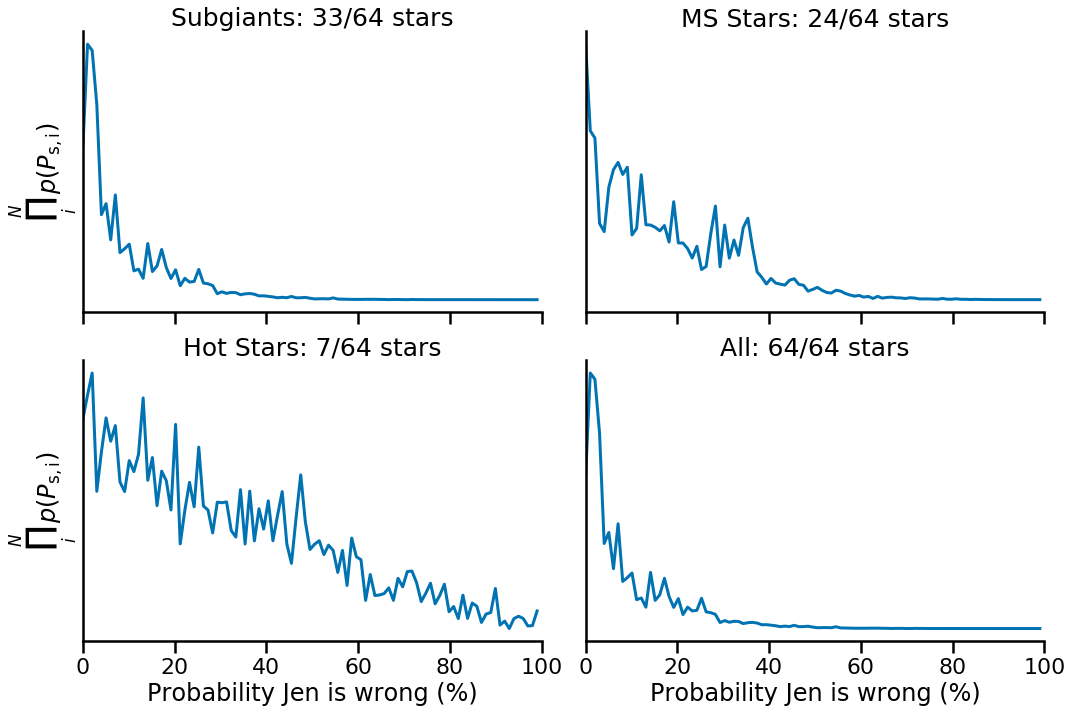

In [15]:
fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel[sg])}/{len(f[sel])} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)

ax[1].plot(bins[:-1], np.prod(hists_sel[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel[ms])}/{len(f[sel])} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)

ax[2].plot(bins[:-1], np.prod(hists_sel[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel[h])}/{len(f[sel])} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)

ax[3].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[3].set_title(fr'All: {len(hists_sel)}/{len(f[sel])} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

## Finally, let's plot the stars in this final example

In [16]:
standard = pd.read_csv('../data/jvs_models/standard_model.csv', index_col=None)
standard.rename(columns={'# Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
standard.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


In [17]:
rocrit = pd.read_csv('../data/jvs_models/rocrit_model.csv', index_col=None)
rocrit.rename(columns={'#Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
rocrit.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


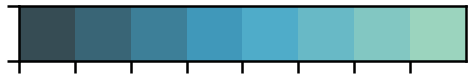

In [18]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

In [19]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'

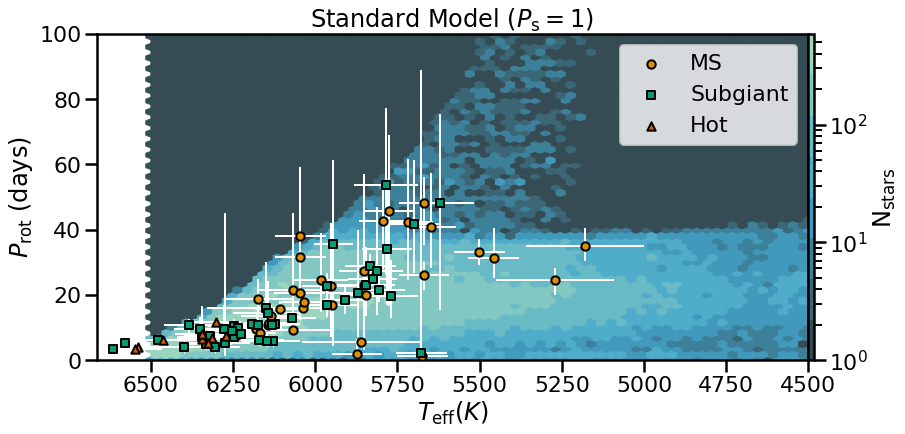

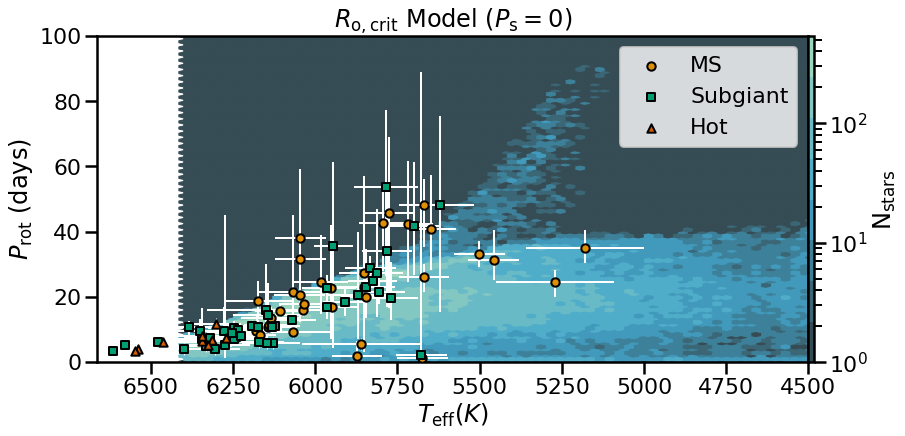

In [29]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.Teff[ms], ati.P[ms], marker='o', s=70,zorder=3, ec='k', lw='2', label='MS')
# ax.scatter(ati.Teff[ms], ati.P[ms], c='k', marker='o', s=100,zorder=2)

ax.scatter(ati.Teff[sg], ati.P[sg], marker=',', s=70,zorder=3, ec='k', lw='2', label='Subgiant')
# ax.scatter(ati.Teff[sg], ati.P[sg], c='k', marker=',', s=100,zorder=2)

ax.scatter(ati.Teff[h], ati.P[h], marker='^', s=70,zorder=3, ec='k', lw='2', label='Hot')
# ax.scatter(ati.Teff[h], ati.P[h], c='k', marker='^', s=100,zorder=2)

ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(ati.Teff.max()+50, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
plt.show()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.Teff[ms], ati.P[ms], marker='o', s=70,zorder=3, ec='k', lw='2', label='MS')
ax.scatter(ati.Teff[sg], ati.P[sg], marker=',', s=70,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(ati.Teff[h], ati.P[h], marker='^', s=70,zorder=3, ec='k', lw='2', label='Hot')

ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(ati.Teff.max()+50, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
plt.show()

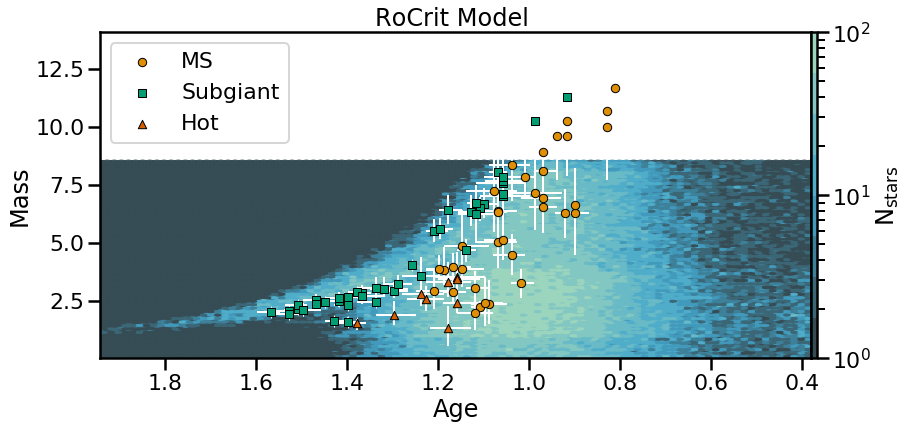

In [24]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.M, rocrit.Age, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.modmass[ms], ati.age[ms], marker='o', s=70,zorder=3, ec='k', lw='1', label='MS')

ax.scatter(ati.modmass[sg], ati.age[sg], marker=',', s=70,zorder=3, ec='k', lw='1', label='Subgiant')

ax.scatter(ati.modmass[h], ati.age[h], marker='^', s=70,zorder=3, ec='k', lw='1', label='Hot')

ax.errorbar(ati.modmass, ati.age, c='w', lw=2,
            xerr=[ati.lomodmass, ati.upmodmass], yerr=[ati.loage, ati.upage], fmt='|', zorder=1)

ax.set_ylabel(r'Mass')
ax.set_xlabel(r'Age')
ax.set_title('RoCrit Model ')
ax.legend(loc='upper left')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

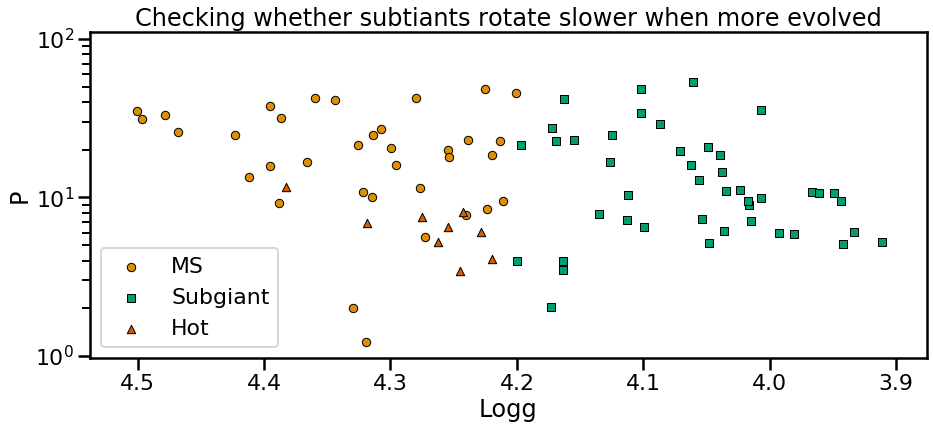

In [35]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.modlogg[ms], ati.P[ms], marker='o', s=70,zorder=3, ec='k', lw='1', label='MS')

ax.scatter(ati.modlogg[sg], ati.P[sg], marker=',', s=70,zorder=3, ec='k', lw='1', label='Subgiant')

ax.scatter(ati.modlogg[h], ati.P[h], marker='^', s=70,zorder=3, ec='k', lw='1', label='Hot')

ax.errorbar(ati.modlogg, ati.P, c='w', lw=2,
            xerr=[ati.lomodlogg, ati.upmodlogg], yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_yscale('log')
ax.set_ylabel(r'P')
ax.set_xlabel(r'Logg')
ax.set_title('Checking whether subtiants rotate slower when more evolved')
ax.legend(loc='lower left')